In [1]:
import sys
sys.path.insert(0, "../")

import numpy as np

import scipy.io as sio
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from torch.autograd import grad
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch.optim.lr_scheduler import ExponentialLR

from scipy.interpolate import griddata
from itertools import product, combinations

from torch.optim.lr_scheduler import ExponentialLR, MultiStepLR
from tqdm import tqdm_notebook as tqdm 
from PINNsUtil import *
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device ='cpu'
print(device)

from polynomial_nets import CP_L3, CP_L3_sparse, NCP_L3, CP, Chebyshev, Chebyshev_L3, ProdCheby, ProdCheby2, ProdCheby_NL 

/home/ashish-razer/Programs/miniconda3/envs/pytorch/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cpu


In [2]:
from matplotlib import style
import matplotlib
matplotlib.rcdefaults() 

In [ ]:
import pickle
# Saving the objects:
path_data = '/home/suarez08/PhD_PINNs/Benchmark_Dominik/Data_Simulations/Poisson_2D_Sobolev/Poisson2d_data.pckl'
#if not os.path.exists(path_data):
#    os.mknod(path_data)
#with open(path_data, 'wb') as f:  # Python 3: open(..., 'wb')
#    pickle.dump([grid_res, w_res, Dx_res, Jf_res, Xb_grd, w_x, Dx_x, Jf_x], f)

# Getting back the objects:
with open(path_data, 'rb') as f:  # Python 3: open(..., 'rb')
    grid_res, w_res, Dx_res, Jf_res, Xb_grd, w_x, Dx_x, Jf_x = pickle.load(f)
grid_ini, w_ini, Dx_ini, Jf_ini = grid_res, w_res, Dx_res, Jf_res

seed 1
scale 6
method 0


/tmp/ipykernel_235891/210804097.py:28: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  yt = np.zeros((u_sol.size, 1), dtype=np.float)


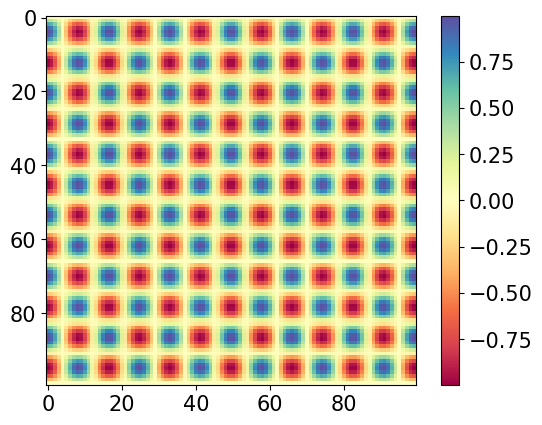

In [3]:
matplotlib.rcParams.update({'font.size': 15})
# experiment setup
scale  = 6
method = 0 # 0 - inverse dirichlet, 2 - maxavg, 3 - mgda, 4 - uniform, 5 - epsilon optimal
seed   = 1

print("seed", seed)
print("scale", scale)
print("method", method)

# genereate ground truth
def poisson_equation(x,y,omega):
    return np.cos(omega*x)*np.sin(omega*y)

x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)

omega = scale*np.pi
xx,yy = np.meshgrid(x,y)
u_sol = poisson_equation(xx,yy,omega)

plt.imshow(u_sol, cmap="Spectral")
plt.colorbar()

# generate training data
X = np.vstack([xx.ravel(), yy.ravel()]).T

yt = np.zeros((u_sol.size, 1), dtype=np.float)
for i,_x in enumerate(u_sol.real.T):
    yt[i*len(x):(i+1)*len(x)] = _x.reshape(len(x),1)

xb = np.linspace(-1,1,100)
yb = np.linspace(-1,1,100)

# X boundaries
lb   = np.min(xb)*np.ones((yb.shape))
Xlb  = np.vstack((lb,yb)).T
UXlb = np.cos(omega*Xlb[:,0])*np.sin(omega*Xlb[:,1])

rb   = np.max(xb)*np.ones((yb.shape))
Xrb  = np.vstack((rb,yb)).T
UXrb = np.cos(omega*Xrb[:,0])*np.sin(omega*Xrb[:,1])
    
# Y boundaries
lb   = np.min(yb)*np.ones((xb.shape))
Ylb  = np.vstack((xb,lb)).T
UYlb = np.cos(omega*Ylb[:,0])*np.sin(omega*Ylb[:,1])
    
rb   = np.max(yb)*np.ones((xb.shape))
Yrb  = np.vstack((xb,rb)).T
UYrb = np.cos(omega*Yrb[:,0])*np.sin(omega*Yrb[:,1])

seedc = seed
np.random.seed(seedc)
torch.manual_seed(seedc)

# training tensors
idxs = np.random.choice(yt.size, 961, replace=False)
X_train = torch.tensor(X[idxs], dtype=torch.float32, requires_grad=True,device=device)
y_train = torch.tensor(yt[idxs], dtype=torch.float32, device=device)

X_rb = torch.tensor(Xrb, dtype=torch.float32, device=device)
X_lb = torch.tensor(Xlb, dtype=torch.float32, device=device)

Y_rb = torch.tensor(Yrb, dtype=torch.float32, device=device)
Y_lb = torch.tensor(Ylb, dtype=torch.float32, device=device)

U_X_rb = torch.tensor(UXrb, dtype=torch.float32, device=device).reshape(100,1)
U_X_lb = torch.tensor(UXlb, dtype=torch.float32, device=device).reshape(100,1)
U_Y_rb = torch.tensor(UYrb, dtype=torch.float32, device=device).reshape(100,1)
U_Y_lb = torch.tensor(UYlb, dtype=torch.float32, device=device).reshape(100,1)

TD = np.concatenate([X[idxs], Xrb, Xlb, Yrb, Ylb], 0)

# compute mean and std of training data
X_mean = torch.tensor(np.mean(TD, axis=0, keepdims=True), dtype=torch.float32, device=device)
X_std  = torch.tensor(np.std(TD, axis=0, keepdims=True), dtype=torch.float32, device=device)

In [4]:
# computes pde residual
def poisson_res(uhat, data, omega):
    poly = torch.ones_like(uhat)
    
    du = grad(outputs=uhat, inputs=data, 
              grad_outputs=torch.ones_like(uhat), create_graph=True)[0]
    
    dudx = du[:,0:1]
    dudy = du[:,1:2]
    
    dudxx = grad(outputs=dudx, inputs=data, 
              grad_outputs=torch.ones_like(uhat), create_graph=True)[0][:,0:1]
    dudyy = grad(outputs=dudy, inputs=data, 
              grad_outputs=torch.ones_like(uhat), create_graph=True)[0][:,1:2]
    
    xin = data[:,0:1]
    yin = data[:,1:2]
    
    source = -2.0*omega*omega*torch.cos(omega*xin)*torch.sin(omega*yin) + 0*uhat
    
    residual = dudxx + dudyy - source
                
    return residual
class sine(nn.Module):
    def forward(self,x):
        return torch.sin(x)

In [5]:
# computes pde residual
def d4u(uhat, data):
    uhat = uhat.reshape(-1,1)
    
    du = grad(outputs=uhat, inputs=data, 
              grad_outputs=torch.ones_like(uhat), create_graph=True)[0]
    dudx = du[:,0:1]

    dudxx = grad(outputs=dudx, inputs=data, 
              grad_outputs=torch.ones_like(uhat), create_graph=True)[0][:,0:1]
    dudxxx = grad(outputs=dudxx, inputs=data, 
              grad_outputs=torch.ones_like(uhat), create_graph=True)[0][:,0:1]
    dudxxx = grad(outputs=dudxxx, inputs=data, 
              grad_outputs=torch.ones_like(uhat), create_graph=True)[0][:,0:1]
    
    residual = dudxxx#dudxx.T[0]   +f + 0*uhat.T[0]
                
    return residual.T[0]

In [6]:
net = PINNNoWN(sizes=[2,50,50,50,50,50,1], mean=X_mean, std=X_std, seed=seedc, activation=sine()).to(device)
start = time.time()
d4u(net(X_train).T[0], X_train)
end = time.time()
print('time consumption: %.4fs' % (end-start))

time consumption: 0.0499s


In [7]:
net(torch.tensor(X_train.detach().numpy(),dtype= torch.float32))

tensor([[-3.6985e-01],
        [ 9.7013e-02],
        [ 7.3493e-02],
        [ 2.7490e-01],
        [-1.2221e-01],
        [-4.5320e-01],
        [ 1.9257e-01],
        [ 4.2811e-01],
        [ 1.5688e-01],
        [-2.3479e-01],
        [-4.4335e-01],
        [ 4.5950e-02],
        [-3.5148e-01],
        [ 1.4012e-01],
        [-2.1970e-02],
        [-2.9607e-01],
        [-1.5872e-01],
        [-7.7464e-02],
        [-1.0230e-01],
        [-2.4409e-01],
        [-1.0307e-01],
        [-3.3783e-02],
        [ 3.8873e-01],
        [ 3.3093e-01],
        [ 3.5375e-01],
        [ 2.7650e-01],
        [ 4.2567e-01],
        [-1.0187e-01],
        [-1.2938e-01],
        [-5.2390e-03],
        [ 3.6459e-01],
        [-2.8037e-01],
        [-2.4353e-01],
        [-1.6353e-01],
        [-3.6269e-01],
        [ 4.6817e-01],
        [-2.6433e-01],
        [ 1.2823e-01],
        [-2.1767e-01],
        [ 2.9781e-01],
        [ 2.2753e-01],
        [ 3.7906e-01],
        [ 3.1119e-01],
        [-9

In [15]:
%%time
net = PINNNoWN(sizes=[2,50,50,50,50,1], mean=X_mean, std=X_std, seed=seedc, activation=sine()).to(device)
net = ProdCheby_NL([2, 40, 30, 30], [3, 3, 3], 1, nn.Tanh()).to(device)
#net = Chebyshev(5, 2, 400, 1).to(device)
print("#parameters:", sum(p.numel() for p in net.parameters() if p.requires_grad))
n_epochs   = 1000
lamb  = 1
losses_bc  = [];
losses_reg = [];
params = [{'params': net.parameters(), 'lr': 1e-3}]
milestones = [[30000]]
optimizer = Adam(params)
scheduler = MultiStepLR(optimizer, milestones[0], gamma=0.1)
start_time = time.time()
for epoch in range(n_epochs):
    
    optimizer.zero_grad()
    uhat  = net(X_train)
    res   = poisson_res(uhat, X_train, omega)
    l_reg = torch.mean((res)**2)
    
    predl = net(X_lb)
    predr = net(X_rb)
    l_bc  = torch.mean((predl - U_X_lb)**2, dim=0)
    l_bc += torch.mean((predr - U_X_rb)**2, dim=0)
 
    predl = net(Y_lb)
    predr = net(Y_rb)
    l_bc += torch.mean((predl - U_Y_lb)**2, dim=0)
    l_bc += torch.mean((predr - U_Y_rb)**2, dim=0)
    
    
    loss = l_reg/1000 + l_bc
    losses_bc.append(l_bc.item())
    losses_reg.append(l_reg.item())
    
    loss.backward()

    optimizer.step()
    scheduler.step()
    
    print("epoch {}/{}, loss={:.10f}, lambda={:.4f}, lr={:,.5f}\t\t\t"
          .format(epoch+1, n_epochs, loss.item(), lamb, optimizer.param_groups[0]['lr']), end="\r")
        
elapsed_time = time.time() - start_time
print('CPU time = ',elapsed_time)

#parameters: 9241
CPU time =  27.74382972717285827393, lambda=1.0000, lr=0.00100			
CPU times: user 3min 39s, sys: 2.02 s, total: 3min 41s
Wall time: 27.7 s


In [16]:
X_train.shape

torch.Size([961, 2])

pred rel. linf-error = 1.999584e+00
pred rel. l2-error = 7.170461e-01
pred_rel_std. linf-error = 5.069721e-01


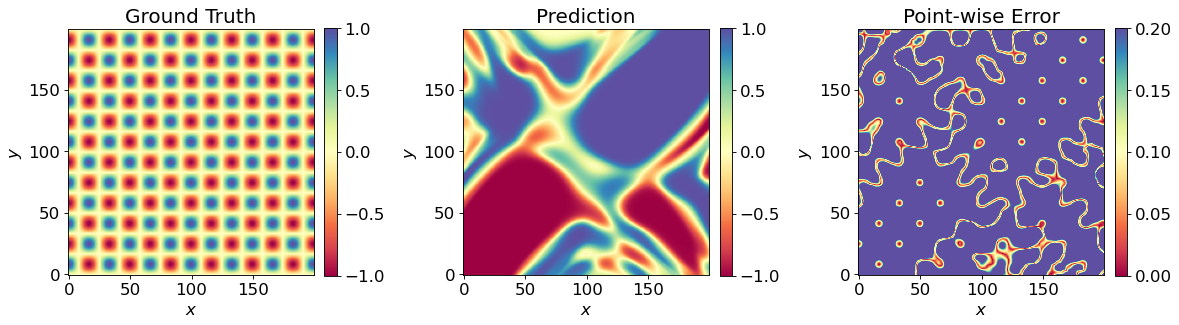

In [17]:
folder = r'/home/ashish-razer/Projects/Polynomial_Nets'
x = np.linspace(-1, 1, 200)
y = np.linspace(-1, 1, 200)
plt.figure(figsize=(15, 25), dpi=80)
xx,yy = np.meshgrid(x,y)
u_sol = poisson_equation(xx,yy,omega)
#u_sol_s = poisson_equation(Xr_s[:,0],Xr_s[:,1],omega)
X = np.vstack([xx.ravel(), yy.ravel()]).T
X_r = X
inp_r = torch.tensor(X_r, dtype=torch.float32, device=device)
inp_r.requires_grad = True
inp = torch.tensor(X, dtype=torch.float32, device=device)
out = net(inp).cpu().data.numpy().reshape(u_sol.shape)
#out = N_p()._eval(X_r).reshape(100,100)
L0_inf = np.max(abs(out.reshape(-1)-u_sol.reshape(-1)))
#Lp_inf = torch.max(abs(poisson_residual(net_s(inp_r),inp_r,omega).reshape(-1)))
L0_mean =np.mean(abs(out.reshape(-1)-u_sol.reshape(-1)))
print("pred rel. linf-error = {:e}".format(L0_inf))
print("pred rel. l2-error = {:e}".format(L0_mean))
#print("pde res. linf-error = {:e}".format(Lp_inf))
print("pred_rel_std. linf-error = {:e}".format(np.std(abs(out.reshape(-1)-u_sol.reshape(-1)))))
plt.subplot(1,3,1)
plt.imshow(u_sol, cmap="Spectral", origin="lower")
#plt.xticks(np.arange(0,len(x)+1,25), np.arange(0, 1.1, 0.25))
#plt.yticks(np.arange(0,len(y)+1,25), np.arange(0, 1.1, 0.25))
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.title("Ground Truth")
plt.clim(-1,1)
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(1,3,2)
plt.imshow(out, cmap="Spectral", origin="lower")
#plt.xticks(np.linspace(0,len(x)+1,5),np.linspace(-1, 1, 5))
#plt.yticks(np.linspace(0,len(x)+1,5),np.linspace(-1, 1, 5))
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.title("Prediction")
plt.clim(-1,1)
plt.colorbar(fraction=0.046, pad=0.04)
#plt.subplots_adjust(wspace=0, hspace=0)
plt.subplot(1,3,3)
plt.imshow(np.abs(out-u_sol)/np.max(np.abs(u_sol)), cmap="Spectral", origin="lower")
#plt.xticks(np.linspace(0,len(x)+1,5),np.linspace(-1, 1, 5))
#plt.yticks(np.linspace(0,len(x)+1,5),np.linspace(-1, 1, 5))
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.title("Point-wise Error")
plt.clim(0,0.2)
plt.colorbar(fraction=0.046, pad=0.04)

#plt.gcf().set_size_inches(14,4)
plt.tight_layout()
#plt.savefig(folder + 'pred_error_MSE.png',bbox_inches='tight')